# Vector Semantics Lab

This lab has mostly explorative character. Please modify parameters and see how this impacts results. There are questions (marked with a <font size="6">🧐</font>) you should attempt to answer, but no formal submission is needed. You are of course welcome to ask for the answer.

## Cosine Similarity
We can compute the Cosine distance between 1-D arrays using scipy. It is defined as such:

  $cos(u, v) = 1 - \frac{u \cdot v}
              {||u||_2 ||v||_2} = 
              1 - \frac{\sum_{i=1}^{d}u_{i}v_i}
                   {\sqrt{\sum_{i=1}^{d}u_i^2  }   \sqrt{\sum_{i=1}^{d}v_i^2  }}$
              
              
Note, this is a distance, rather than a similarity measure, due to the $1 - \ldots$. Its values are between 0 (identical vectors or those pointing in the same direction) and 1 (orthogonal vectors). As all $u_i$ and $v_i$ are positive (why?) <font size="6">🧐</font>, so will be $cos(u,v)$.

In [341]:
## Some imports
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models import HoverTool
output_notebook()
import pandas as pd

Loading BokehJS ...

In [342]:
from scipy.spatial.distance import cosine as cos
cos?

### A little cosine warmup
Get a feel for it by changing the values such that you create large and small distances.
Can you compare vectors of different sizes? Can you compare the null vector? What happened in the last example? <font size="6">🧐</font>

In [343]:
cos([10,0,0], [9,0,2])

0.023812939816047263

In [344]:
cos([10,0,0], [0,10,3])

1.0

In [345]:
cos([5,2,1], [15,6, 3])

0

Let's reimplement the lecture slides.
Use the cosine distance measure to estimate similarity between documents. <font size="6">🧐</font>
Recall the Term document matrix from the slides
![title](Images/slide_termdoc.png)
![title](Images/slide_termdoc2.png)
Recreate t the take-away message that the comedies ("As You Like It" and "Twelfth Night") are similar to each other and different from the dramas, or at least, they should be!
Try with two dimensions (like battle and fool) and keep adding to see, how similarities change. <font size="6">🧐</font>

A dataframe is quite convenient for this matter:

In [346]:
titles = ['As you like it','Twelfth Night', 'Julius Caesar','Henry V']
words = 'battle good fool wit'.split()
df = pd.DataFrame([[1,0,7,13],
                   [114,80,62,89],
                   [36,58,1,4],
                   [20,15,2,3]], columns=titles, index=words)
df

,As you like it,Twelfth Night,Julius Caesar,Henry V
battle,1,0,7,13
good,114,80,62,89
fool,36,58,1,4
wit,20,15,2,3


In [347]:
cos(df['As you like it'], df['Twelfth Night'])

0.05008748968390353

Ok, makes sense.

In [348]:
cos(df['As you like it'], df['Julius Caesar'])

0.05508961665396295

Still small (distance). How come? <font size="6">🧐</font>

In [349]:
# Hint: here is how you can choose a subset of words
df.loc[['battle', 'fool']]

,As you like it,Twelfth Night,Julius Caesar,Henry V
battle,1,0,7,13
fool,36,58,1,4


### Words can be vectors too!
Find the cosine distances between the words.
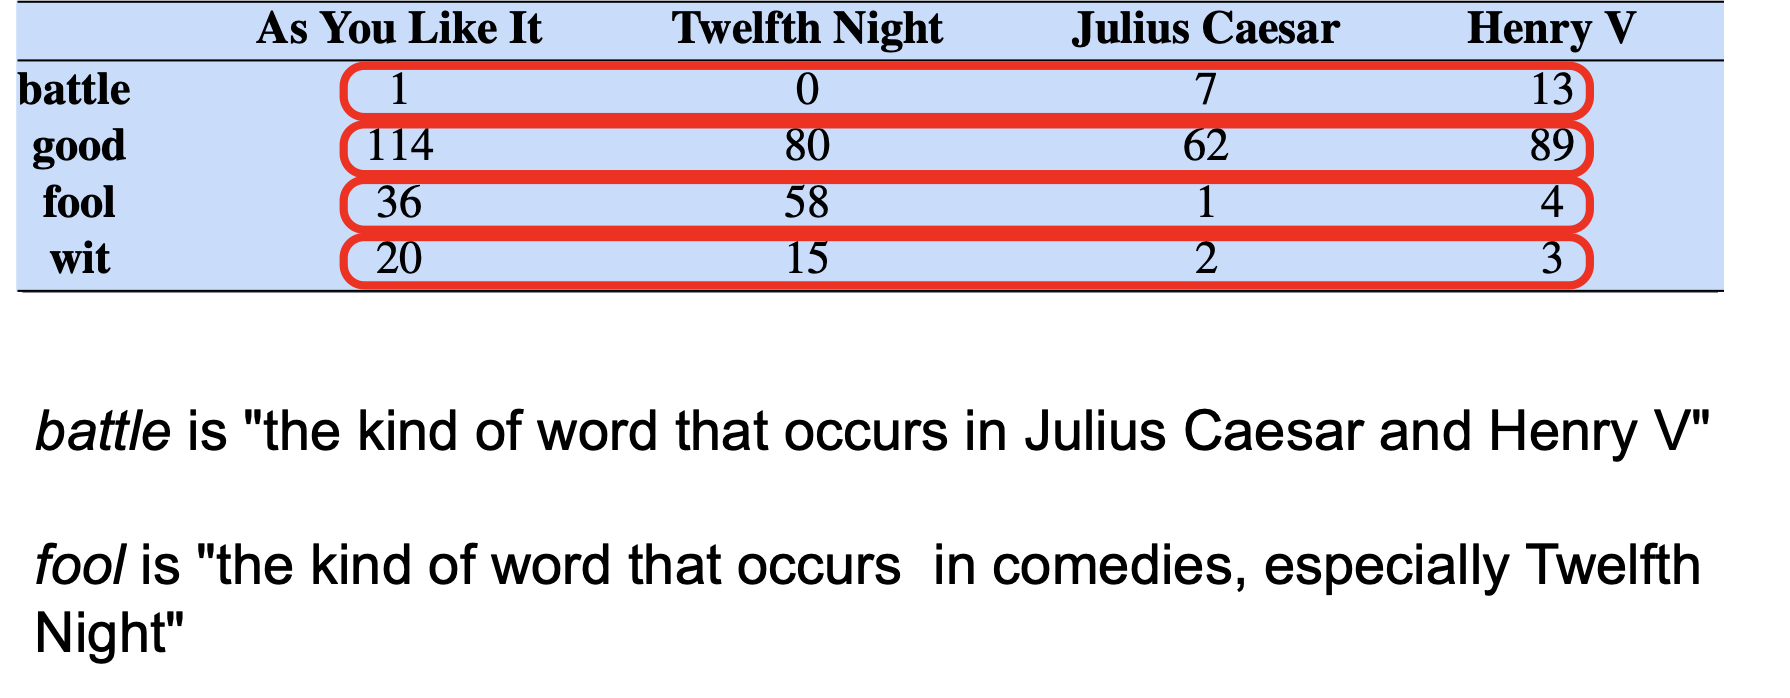

### All against all comparison
Try to understand the code below.
The scipy function pdist performs a pairwise comparison:
https://lmgtfy.app/?q=scipy+pdist&iie=1
and it can also handle dataframes as input. Its second argument is a function(!), you are doing functional programming at this point. This is pretty advanced, so time to pad yourself on the shoulder 😉
pdist returns a one dimensional array, and squareform brings this into an $n \times n$ shape, where $n$ is the number of columns of your input dataframe/array.
Seaborn is a nice convenient visualization library.

<AxesSubplot:>

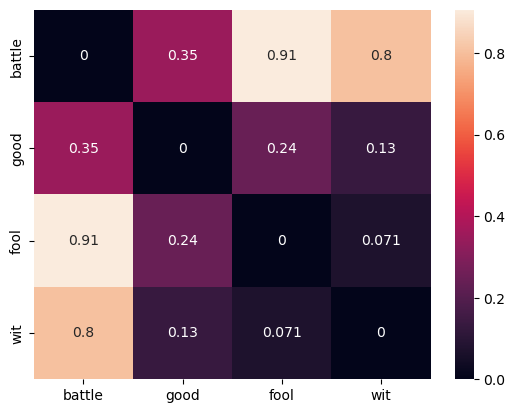

In [350]:
from scipy.spatial.distance import squareform, pdist
import seaborn as sns
allVsall = squareform(pdist(df, cos))
dm = pd.DataFrame(allVsall, index=df.index, columns=df.index)
sns.heatmap(dm, annot=True)

Explain, what is going on int the figure above. Do the same for documents (see below). Hint: transpose. <font size="6">🧐</font>

<AxesSubplot:>

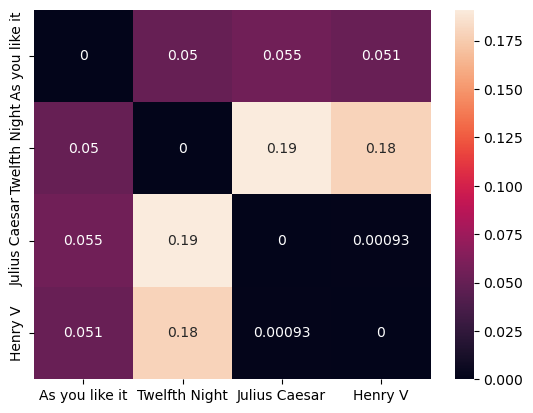

In [351]:
df = df.T
allVsall = squareform(pdist(df, cos))
dm = pd.DataFrame(allVsall, index=df.index, columns=df.index)
sns.heatmap(dm, annot=True)

### TF-IDF
We've seen how ubiquitous words can destroy similarity (or rather, create a false positive similarity, in the case of "Julius Caesar" (drama) and "As you like it". TF-IDF to the rescue! While gensim has this implemented, we would like to use it for our term-document matrix above, so we quickly implement it for such datatypes ourselves. <font size="6">🧐</font>

Recall that tf-idf is defined like so

$w_{t,d} = \mathit{tf}_{t,d} \times \mathit{idf}_t $


$ = \mathit{log}_{10}(\mathit{count}(t,d) + 1) \times  \mathit{log}_{10}(\frac{N}{\mathit{df}_t})$

Note that most words occur everywhere at least once, when documents are entire books, so $\mathit{idf}_t = 0, \forall t \in V$ (or almost), so in practice documents are broken down into smaller paragraphs. For our little example, we set any count smaller than 10 to 0, to see some effect.

In [352]:
df[df<7]=0
df

,battle,good,fool,wit
As you like it,0,114,36,20
Twelfth Night,0,80,58,15
Julius Caesar,7,62,0,0
Henry V,13,89,0,0


In [353]:
#np.log10(1)
#def tfidf(termdoc):

def tfidf(row): ## row is a pandas series
    N = len(row)
    dft = len(row[row>0])
    idf = np.log10(N/dft)    
    tf = np.log10(row+1)
    return tf*idf
    
df2 = pd.DataFrame([tfidf(row) for i, row in df.iterrows()])
df2



,battle,good,fool,wit
As you like it,0.000000,0.257461,0.195929,0.165196
Twelfth Night,0.000000,0.238444,0.221248,0.150441
Julius Caesar,0.271857,0.541655,0.000000,0.000000
Henry V,0.345019,0.588286,0.000000,0.000000


In [354]:
cos(df2.loc['good'], df2.loc['wit'])

KeyError: 'good'

## Word2vec with Gensim
Loading the models might take some time, especially if they need to be downloaded (only the first time).

In [355]:
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

In [356]:
api.info()

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1, 'record_format': 'dict', 'file_size': 6344358, 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py', 'license': 'All files released for the task are free for general research use', 'fields': {'2016-train': ['...'], '2016-dev': ['...'], '2017-test': ['...'], '2016-test': ['...']}, 'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.', 'checksum': '701ea67acd82e75f95e1d8e62fb0ad29', 'file_name': 'semeval-2016-2017-task3-subtaskBC.gz',

In [357]:
## also load GloVe, for comparison
glove = api.load("glove-twitter-200")

In [403]:
api.info("glove-twitter-200")

{'num_records': 1193514, 'file_size': 795373100, 'base_dataset': 'Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased)', 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-twitter-200/__init__.py', 'license': 'http://opendatacommons.org/licenses/pddl/', 'parameters': {'dimension': 200}, 'description': 'Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/).', 'preprocessing': 'Converted to w2v format with `python -m gensim.scripts.glove2word2vec -i <fname> -o glove-twitter-200.txt`.', 'read_more': ['https://nlp.stanford.edu/projects/glove/', 'https://nlp.stanford.edu/pubs/glove.pdf'], 'checksum': 'e52e8392d1860b95d5308a525817d8f9', 'file_name': 'glove-twitter-200.gz', 'parts': 1}

Alternatively, load other models, check them out with api.info()

In [298]:
api.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [299]:
for kv in api.info('glove-wiki-gigaword-200').items():
    print('%-20s : %s' % kv)

num_records          : 400000
file_size            : 264336934
base_dataset         : Wikipedia 2014 + Gigaword 5 (6B tokens, uncased)
reader_code          : https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-wiki-gigaword-200/__init__.py
license              : http://opendatacommons.org/licenses/pddl/
parameters           : {'dimension': 200}
description          : Pre-trained vectors based on Wikipedia 2014 + Gigaword, 5.6B tokens, 400K vocab, uncased (https://nlp.stanford.edu/projects/glove/).
preprocessing        : Converted to w2v format with `python -m gensim.scripts.glove2word2vec -i <fname> -o glove-wiki-gigaword-200.txt`.
read_more            : ['https://nlp.stanford.edu/projects/glove/', 'https://nlp.stanford.edu/pubs/glove.pdf']
checksum             : 59652db361b7a87ee73834a6c391dfc1
file_name            : glove-wiki-gigaword-200.gz
parts                : 1


### Exploring the pretrained Word2vec model
Let's find the longest word, just for fun, and for recap'ing on regular expressions. <font size="6">🧐</font>

In [300]:
import re
## find the longest word, starting with a letter (allow '-', ' ' (space) and '_')
word = re.compile('[A-Za-z][A-Za-z0-9-_ ]+$')
max([k for k in model.key_to_index if word.match(k)], key=lambda x:len(x))

'FINANCIAL_HIGHLIGHTS_----------------------------------------------------------'

In [301]:
## creating some vectors
arsenal = model['arsenal']
weaponry = model['weaponry']
apricot = model['apricot']
jam = model['jam']
arsenal

array([ 2.83203125e-01,  3.33984375e-01,  4.29687500e-01, -1.63085938e-01,
        3.34472656e-02,  3.73046875e-01, -1.52343750e-01, -7.71484375e-02,
        3.19824219e-02,  6.64062500e-02,  1.14746094e-01, -2.77343750e-01,
        4.46777344e-02,  1.80664062e-01, -7.81250000e-02, -2.06298828e-02,
        1.59179688e-01,  1.58203125e-01, -1.95312500e-02, -1.74804688e-01,
        6.29882812e-02, -1.66015625e-01,  1.09863281e-01,  1.52343750e-01,
        7.47070312e-02, -3.06640625e-01, -6.54296875e-02, -1.42211914e-02,
       -2.57812500e-01,  9.88769531e-03, -4.58984375e-02, -1.77001953e-02,
       -2.24609375e-01,  4.98046875e-02, -1.23901367e-02,  1.36718750e-01,
        2.07519531e-02,  1.93359375e-01,  2.87109375e-01, -1.73828125e-01,
        2.65625000e-01,  5.93261719e-02,  3.32031250e-02,  8.17871094e-03,
       -2.99072266e-02, -2.42187500e-01,  1.09252930e-02,  2.01416016e-02,
       -1.16699219e-01, -2.25830078e-02,  7.91015625e-02, -9.66796875e-02,
       -1.38854980e-03, -

### Hierarchical clustering
A common approach to deal with high dimensional vectors is to compare and visualize using hierarchical clustering.
We will use seaborn's clustermap. Your matrix will be clustered in both dimensions, i.e., in terms of features and in terms of words/terms. Does the top-level clustering of the below terms make sense? <font size="6">🧐</font>
Seaborn's clustermap can take a distance measure and defaults to 'euclidean'. Can you change it to cosine? <font size="6">🧐</font> (Hint: similar to pdist)

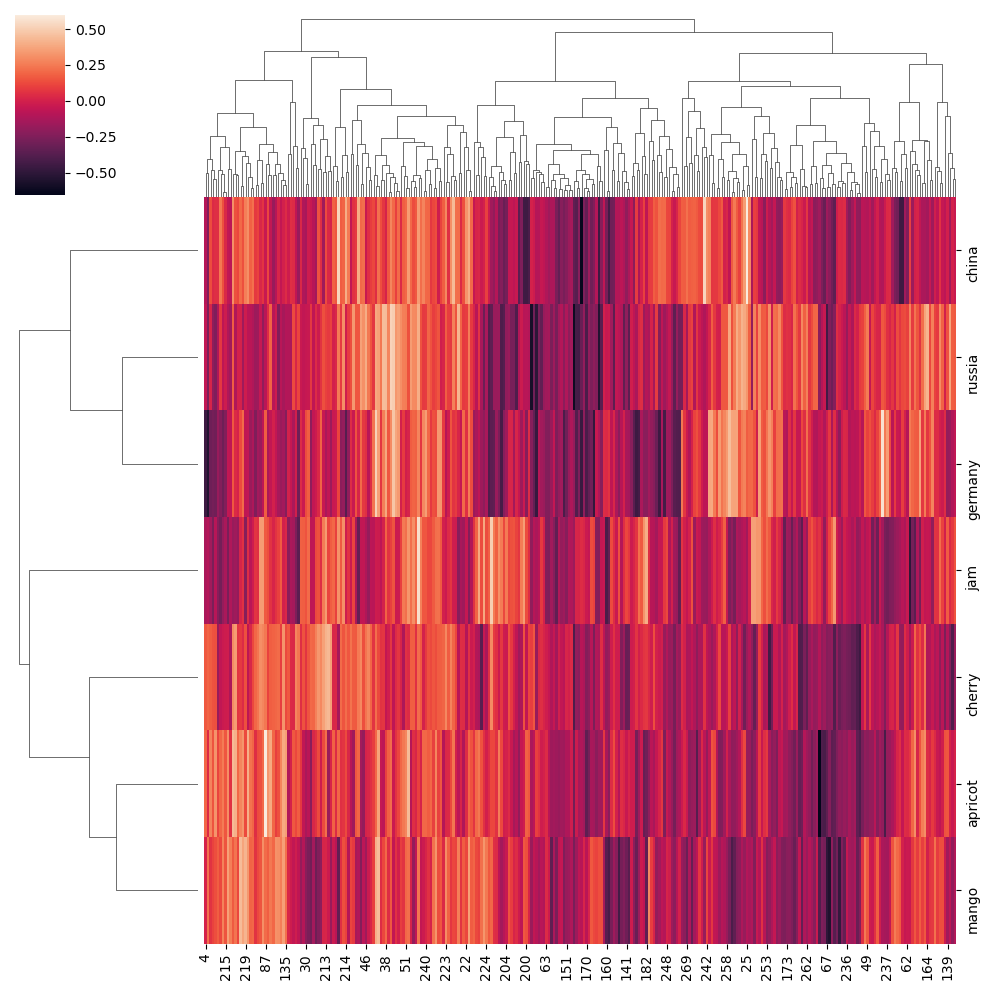

In [302]:
terms = 'china russia germany apricot jam mango cherry'.split()
df = pd.DataFrame(model[terms], index=terms)
sns.clustermap(df, metric=cos)

In [303]:
cos(arsenal, weaponry)

0.44285231828689575

In [304]:
cos(12*arsenal + jam, arsenal)

0.0035750865936279297

In [305]:
cos(12*arsenal, 3*arsenal) 

0

Explain, why is this close to 0 and 0, respectively? <font size="6">🧐</font>

Explore the similarity of related and unrelated word pairs. List them and calulate all similarities, using model.similarity. Compare models. <font size="6">🧐</font>

In [306]:
help(model.similarity)

Help on method similarity in module gensim.models.keyedvectors:

similarity(w1, w2) method of gensim.models.keyedvectors.KeyedVectors instance
    Compute cosine similarity between two keys.
    
    Parameters
    ----------
    w1 : str
        Input key.
    w2 : str
        Input key.
    
    Returns
    -------
    float
        Cosine similarity between `w1` and `w2`.



In [307]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]


In [308]:
## is it the same ranking for glove?
for w1, w2 in pairs:
    print(w1, w2, model.similarity(w1, w2))

car minivan 0.69070363
car bicycle 0.5364485
car airplane 0.42435578
car cereal 0.13924746
car communism 0.058202937


### The odd one out 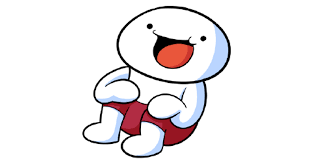
Play with the below example and find a funny example.

In [309]:
model.doesnt_match('apple pear cherry truck'.split())

'truck'

In [310]:
model.doesnt_match('manchester city,liverpool,arsenal,barcelona'.split(','))

'arsenal'

### Analogy relations: the Parallelogram test
Look at the example below and write a function parallelogram that given three words a, b, c, it returns the closest words to $\overrightarrow{a} - \overrightarrow{b} + \overrightarrow{c}$.
Hint: model.similar_by_vector 

"Apple is to tree as grape is to ..."
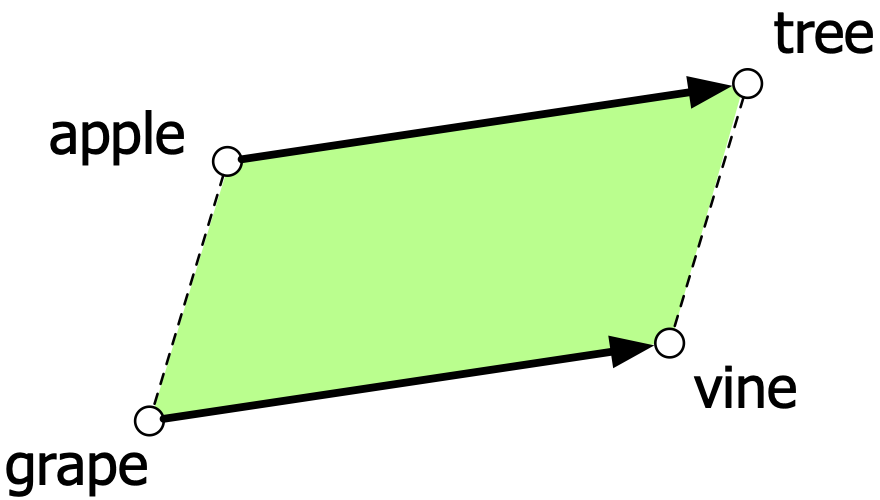
$\overrightarrow{tree} - \overrightarrow{apple} + \overrightarrow{grape} \stackrel{?}{=} \overrightarrow{vine}$

In [311]:
cos(model['tree'] - model['apple'] + model['grape'], model['vine'])

0.4407767057418823

In [312]:
def parallelogram(model,a,b,c, **kwargs):
    k = model[a] - model[b] + model[c]
    return model.similar_by_vector(k, **kwargs)

In [313]:
parallelogram(model, 'paris', 'france', 'japan', topn=3)

[('japan', 0.7073737978935242), ('paris', 0.636668860912323), ('tokyo', 0.4821012318134308)]

### Cultural bias 😱


In [314]:
parallelogram(model, 'computer_programmer', 'man', 'woman', topn=3)

[('computer_programmer', 0.910581111907959), ('homemaker', 0.5771316289901733), ('schoolteacher', 0.5500192046165466)]

In [315]:
for person in 'uncle daughter mother son'.split():
    print(person, parallelogram(model, 'doctor', 'father', person, topn=2))

uncle [('doctor', 0.8943919539451599), ('physician', 0.6969043016433716)]
daughter [('doctor', 0.8321408033370972), ('nurse', 0.6653137803077698)]
mother [('doctor', 0.881921648979187), ('nurse', 0.7165822982788086)]
son [('doctor', 0.9248571991920471), ('physician', 0.7305173277854919)]


## Stock2vec - Visualization of Stock titles
300D vectors aren't easy to visualize. 
We will use PCA and t-SNE to bring the data down to visualizability. First some Pandas fun

In [322]:
!ls -l ../Data

ls: ../Data: No such file or directory


In [327]:
stocks = pd.read_csv('TextClassification/stocktitles.csv').iloc[:,:4]
stocks.head()

,Symbol,Company Name,Industry,Market Cap
0,A,Agilent Technologies,Life Sciences Tools & Services,39.17B
1,AA,Alcoa,Metals & Mining,7.14B
2,AAC,Ares Acquisition,Blank Check / SPAC,1.24B
3,AACG,ATA Creativity Global,Diversified Consumer Services,59.72M
4,AACI,Armada Acquisition I,Blank Check / SPAC,205.65M


In [329]:
len(set(stocks['Company Name']))

6171

In [330]:
## Fixing the market cap
def numeric(mc):
    if mc.endswith('-'): return 0
    v = float(mc[:-1].replace(',',''))
    if mc.endswith('M'): return v
    if mc.endswith('B'): return 1000*v
    
from collections import Counter
Counter([mc[-1] for mc in stocks['Market Cap']])
stocks['MarketCapMil'] = [numeric(mc) for mc in stocks['Market Cap']]
stocks

,Symbol,Company Name,Industry,Market Cap,MarketCapMil
0,A,Agilent Technologies,Life Sciences Tools & Services,39.17B,39170.00
1,AA,Alcoa,Metals & Mining,7.14B,7140.00
2,AAC,Ares Acquisition,Blank Check / SPAC,1.24B,1240.00
3,AACG,ATA Creativity Global,Diversified Consumer Services,59.72M,59.72
4,AACI,Armada Acquisition I,Blank Check / SPAC,205.65M,205.65
...,...,...,...,...,...
7208,ZWS,Zurn Water Solutions,Pollution & Treatment Controls,4.44B,4440.00
7209,ZY,Zymergen,Specialty Chemicals,253.58M,253.58
7210,ZYME,Zymeworks,Biotechnology,346.11M,346.11
7211,ZYNE,Zynerba Pharmaceuticals,Pharmaceuticals,31.27M,31.27


### Choosing top ten industries 
(in terms of market cap)

Pandas allows some very powerful aggregation one-liners:

In [384]:
topInd = stocks.groupby('Industry').sum().sort_values(by='MarketCapMil', ascending=False).head(10)
topInd

,MarketCapMil
Industry,
"Oil, Gas & Consumable Fuels",4384111.39
Software,3899498.19
Interactive Media & Services,3186618.30
Banks,3038584.59
"Technology Hardware, Storage & Periph...",2517810.93
Pharmaceuticals,2442871.89
Semiconductors & Semiconductor Equipment,2171249.25
IT Services,2068068.00
Internet & Direct Marketing Retail,1901844.71


### Slicing and dicing the data set
You can play with the parameters and see, how that effects the final visualization.

In [385]:
glove["msft"]

array([-0.11499  ,  0.43338  ,  0.039842 ,  0.67026  , -0.27617  ,
       -0.17769  ,  0.25309  , -0.36371  , -0.1661   ,  0.53539  ,
       -0.26762  ,  0.13693  , -0.54989  , -1.0143   , -0.029521 ,
       -0.36362  ,  0.37416  ,  0.81956  , -0.022647 , -0.03887  ,
        0.41829  ,  0.25501  ,  0.19334  ,  0.17468  , -0.21721  ,
        0.77038  ,  0.19109  ,  0.055404 , -0.91424  , -0.68135  ,
        0.19868  ,  0.7528   , -0.87204  , -0.38024  ,  0.38756  ,
       -0.42066  ,  0.27794  ,  0.30248  ,  0.34309  ,  0.050808 ,
        0.45887  ,  0.28449  ,  0.22259  ,  0.43764  ,  0.17472  ,
       -1.0175   , -0.30631  , -0.4706   , -0.074713 ,  0.19015  ,
        0.51386  ,  0.14689  , -0.1775   ,  0.8492   , -0.41424  ,
        0.25134  ,  0.29898  ,  0.54949  ,  0.19018  ,  0.86133  ,
       -0.34967  , -0.71477  , -0.24125  , -0.066544 , -0.34764  ,
        0.11241  ,  0.64092  ,  0.48391  , -0.14252  , -0.62661  ,
        0.17205  ,  0.16291  ,  0.17674  , -1.1449   , -0.1416

In [386]:
## keeping only titles within the top 10 industries:
stocks2 = stocks[stocks.Industry.isin(topInd.index)]
## keeping only Symbols with at least 3 letters
stocks2 = stocks2[stocks2.Symbol.str.len()>2]
## within the top industries, just go for the big fish
stocks2 = stocks2[stocks2.MarketCapMil>1000]
## keeping only titles that are in the model (alternative, see fastText)
#stocks2['Symbol'] = stocks2.Symbol.apply(lambda x: x.lower())
stocks2 = stocks2[stocks2.Symbol.isin(model.key_to_index)] ## for glove, convert symbol to lower case
stocks2

,Symbol,Company Name,Industry,Market Cap,MarketCapMil
14,AAPL,Apple,"Technology Hardware, Storage & Periph...","2,310.18B",2310180.0
24,ABCB,Ameris Bancorp,Banks,3.49B,3490.0
67,ACIW,ACI Worldwide,Software,2.56B,2560.0
69,ACLS,Axcelis Technologies,Semiconductors & Semiconductor Equipment,1.68B,1680.0
73,ACN,Accenture,IT Services,166.51B,166510.0
...,...,...,...,...,...
7152,YNDX,Yandex,Interactive Media & Services,6.80B,6800.0
7157,YPF,YPF Sociedad Anonima,"Oil, Gas & Consumable Fuels",5.90B,5900.0
7174,ZEN,Zendesk,Software,9.47B,9470.0
7189,ZION,Zions Bancorporation NA,Banks,7.82B,7820.0


In [387]:
stocks2.Industry.value_counts()

Banks                                       144
Oil, Gas & Consumable Fuels                 125
Software                                     77
Capital Markets                              58
Semiconductors & Semiconductor Equipment     57
IT Services                                  56
Pharmaceuticals                              36
Technology Hardware, Storage & Periph...     17
Internet & Direct Marketing Retail           17
Interactive Media & Services                 14
Name: Industry, dtype: int64

In [388]:
symbols = stocks2.Symbol
stock2vec = pd.DataFrame([model[symbol] for symbol in symbols], index=symbols)## try also with glove (lower case)
stock2vec

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,-0.088867,-0.112793,-0.263672,0.206055,-0.267578,-0.500000,-0.129883,0.259766,0.316406,-0.049805,...,0.279297,0.139648,-0.081543,-0.037354,0.144531,-0.048096,-0.248047,-0.001816,-0.099121,0.382812
ABCB,-0.156250,-0.136719,-0.015625,0.035156,0.103027,-0.031006,0.146484,0.105957,0.043457,-0.038086,...,-0.065430,0.004089,-0.116211,0.089844,0.062500,-0.036377,-0.042236,-0.083496,0.060303,0.101562
ACIW,-0.114258,-0.165039,-0.004333,0.084473,0.084961,-0.008789,0.036621,0.139648,-0.003464,0.031738,...,-0.020264,0.065430,-0.116699,0.007874,0.042725,0.005768,-0.000184,-0.037842,0.014709,0.127930
ACLS,-0.267578,-0.419922,0.187500,0.181641,-0.204102,0.176758,0.083984,-0.092285,-0.159180,-0.449219,...,0.120605,-0.304688,-0.435547,-0.112305,0.215820,-0.197266,-0.012634,0.075684,0.193359,0.423828
ACN,0.079590,-0.361328,-0.079102,-0.058594,-0.208984,-0.361328,-0.462891,0.080566,-0.121582,0.156250,...,-0.285156,-0.015747,-0.071289,0.036865,0.365234,0.049805,0.060059,-0.074707,0.002747,-0.064453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YNDX,-0.062500,0.055176,-0.074707,0.092285,-0.092285,-0.058105,0.053223,-0.032715,0.122070,0.026855,...,0.048340,0.020020,-0.091309,0.044922,0.095703,-0.072754,0.038818,0.065430,0.047363,0.014954
YPF,-0.316406,-0.206055,-0.208008,0.069824,-0.159180,-0.357422,0.287109,-0.107422,0.035889,-0.117188,...,-0.015869,-0.138672,-0.200195,0.120117,0.141602,0.488281,-0.070312,0.402344,-0.369141,0.002167
ZEN,-0.008362,0.153320,-0.013489,0.027832,-0.214844,-0.008728,0.020996,-0.363281,-0.066895,-0.157227,...,-0.049316,0.154297,0.291016,0.042969,0.191406,-0.223633,-0.002060,-0.106445,-0.122070,0.183594


### More disambiguation
Here is an idea: try to modify the stock2vec table, such that not only the symbol but also the industry terms, i.e., their vector(s), define the vector representation. <font size="6">🧐</font> You can preprocess (tokenize) also with gensim:

In [389]:
from gensim.utils import simple_preprocess
simple_preprocess("Semiconductors & Semiconductor Equipment	")

['semiconductors', 'semiconductor', 'equipment']

In [390]:
row = stocks2.iloc[0]
terms = [row.Symbol, 'stock'] + simple_preprocess(row['Industry']) + simple_preprocess(row['Company Name']) 
terms = [term for term in terms if term in model.index_to_key]
print(terms)
model.most_similar(positive=terms, topn=10)

['AAPL', 'stock', 'technology', 'hardware', 'storage', 'apple']


[('Decelles_salesman', 0.6103911995887756), ('gigabyte_iPod_shuffle', 0.6060816645622253), ('iPads_outdoing', 0.6032822132110596), ('Compellent_CML', 0.5960370898246765), ('1GB_iPod_shuffle', 0.5927865505218506), ('LTO4_tape', 0.5914632678031921), ('Apple_Nasdaq_AAPL', 0.5885843634605408), ('Network_Appliance_NTAP', 0.5840845704078674), ('PowerPC_chip', 0.5839260220527649), ('DRAM_SRAM', 0.5836799144744873)]

Note: model can take a list of n words, returns a $n\times300$ matrix


In [391]:
model[terms].shape

(6, 300)

In [378]:
centroid = model[terms].mean(axis=0)
model.similar_by_vector?

In [396]:
def findRelated(row):
    ## complete this function by including more context clues to a symbol, a symbol by itself is afflicted with too much noise
    terms = [row.Symbol, 'stock'] + simple_preprocess(row['Industry']) + simple_preprocess(row['Company Name']) 
    terms = [term for term in terms if term in model.index_to_key]
    return model[terms].mean(axis=0)                                                                         

stock2vec = pd.DataFrame([findRelated(row) for i, row in stocks2.iterrows()], index=stocks2.Symbol)
stock2vec

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,-0.033447,-0.025370,-0.044896,0.065979,-0.081055,-0.050064,0.092896,-0.038605,0.172256,0.135986,...,-0.117025,0.077738,-0.075155,0.005310,0.147685,-0.076294,0.028971,0.052330,-0.016398,0.189865
ABCB,-0.031514,-0.019694,-0.026876,0.158203,0.130208,-0.156820,0.022135,0.076701,0.257975,0.085734,...,-0.162435,0.055237,-0.175903,0.038696,0.177409,0.010498,-0.063883,0.109212,0.017741,0.002930
ACIW,0.062817,-0.163770,-0.005798,0.114160,-0.035596,-0.024500,0.023633,0.017944,0.173184,0.101709,...,-0.022346,0.119873,-0.176855,0.075378,0.100635,-0.026215,0.021570,0.083105,0.028809,0.095605
ACLS,-0.082235,-0.159269,0.146240,0.062581,-0.184082,-0.021098,-0.001851,-0.088440,0.052511,-0.070801,...,-0.104624,-0.003977,-0.175232,0.087850,0.121358,-0.281820,-0.015289,0.045776,0.132141,0.100993
ACN,0.050903,-0.117901,0.002319,0.050354,-0.049561,-0.161224,-0.069244,-0.012665,0.109894,0.079163,...,-0.107666,0.054291,-0.141846,0.049973,0.162109,0.058167,0.117920,0.047661,0.025131,-0.031616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YNDX,0.039648,-0.051282,-0.079980,0.008350,0.018176,-0.061011,0.024521,-0.042920,0.133911,-0.068262,...,-0.064221,-0.013281,-0.127344,0.008966,0.128833,-0.041260,0.101807,0.048187,-0.020435,-0.031799
YPF,-0.080287,0.003034,-0.115792,0.095485,-0.073591,-0.105259,0.039097,-0.262259,0.058524,0.085031,...,-0.078552,-0.063459,-0.144636,0.135263,0.039097,0.073521,0.098598,0.149728,0.054426,0.022352
ZEN,0.089335,-0.082194,-0.026388,0.091309,-0.065104,-0.054179,0.049805,-0.030884,0.173991,0.048096,...,-0.094564,0.160482,-0.054688,0.027140,0.220703,-0.074626,0.085251,0.045003,-0.033203,0.161133


In [401]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
res = pca.fit_transform(stock2vec)
res.shape

(601, 2)

Explore how the clustering looks like with T-SNE instead. The functionality is identical to PCA.
<font size="6">🧐</font>

In [ ]:
api.info("glove-")

In [398]:
#uncomment to show T-SNE clustering
tsne = TSNE(2)
res = tsne.fit_transform(stock2vec)

/Users/ahenschel/Applications/miniconda3/envs/speech/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ahenschel/Applications/miniconda3/envs/speech/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [407]:
import numpy as np
import matplotlib.colors as mcolors
cols = list(mcolors.TABLEAU_COLORS.values())
visDF = pd.DataFrame({'x': res[:,0], 'y': res[:,1], 
                      'label': stocks2.Symbol, 
                      'description': stocks2['Company Name'],
                      'industry': stocks2['Industry'],
                      #'cap': stocks2['MarketCapMil']//10000 #np.log2(stocks2['MarketCapMil']) #
                      'cap': (np.log(stocks2['MarketCapMil']) / np.log(1.001))//1000
                     })
ind2col = {industry: cols[i] for i,industry in enumerate(set(stocks2['Industry']))}
visDF['col'] = [ind2col[ind] for ind in visDF.industry]
visDF

,x,y,label,description,industry,cap,col
14,0.122031,0.442945,AAPL,Apple,"Technology Hardware, Storage & Periph...",14.0,#9467bd
24,-0.755387,-0.316175,ABCB,Ameris Bancorp,Banks,8.0,#2ca02c
67,-0.112123,0.333753,ACIW,ACI Worldwide,Software,7.0,#7f7f7f
69,0.368215,1.214063,ACLS,Axcelis Technologies,Semiconductors & Semiconductor Equipment,7.0,#bcbd22
73,-0.157873,-0.047886,ACN,Accenture,IT Services,12.0,#8c564b
...,...,...,...,...,...,...,...
7152,-0.079608,0.039103,YNDX,Yandex,Interactive Media & Services,8.0,#ff7f0e
7157,0.843436,-0.515251,YPF,YPF Sociedad Anonima,"Oil, Gas & Consumable Fuels",8.0,#e377c2
7174,-0.217272,0.396672,ZEN,Zendesk,Software,9.0,#7f7f7f
7189,-0.681956,-0.357735,ZION,Zions Bancorporation NA,Banks,8.0,#2ca02c


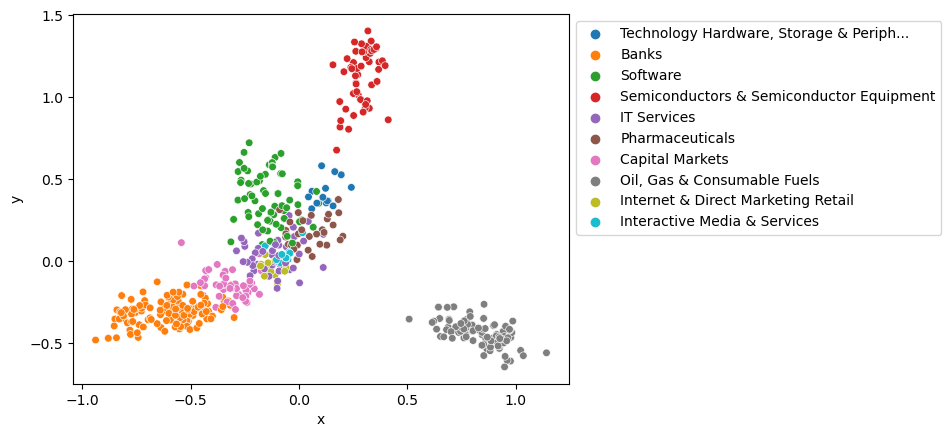

In [408]:
## Plotting with seaborn
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1)
sns.scatterplot(x='x',y='y', data=visDF, hue='industry', ax=ax, s=30)
_=ax.legend(bbox_to_anchor=(1,1), loc=2)

### Interactive graphs with bokeh

In [409]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

cds = ColumnDataSource(visDF)
p = figure(plot_width=800, plot_height=1200, tooltips=[("","@label"), ("title", "@description"), ("name", "@industry"), ("cap", "@cap")])
p.scatter(x='x', y='y', color='col', line_color='black', size='cap', source=cds)
show(p)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


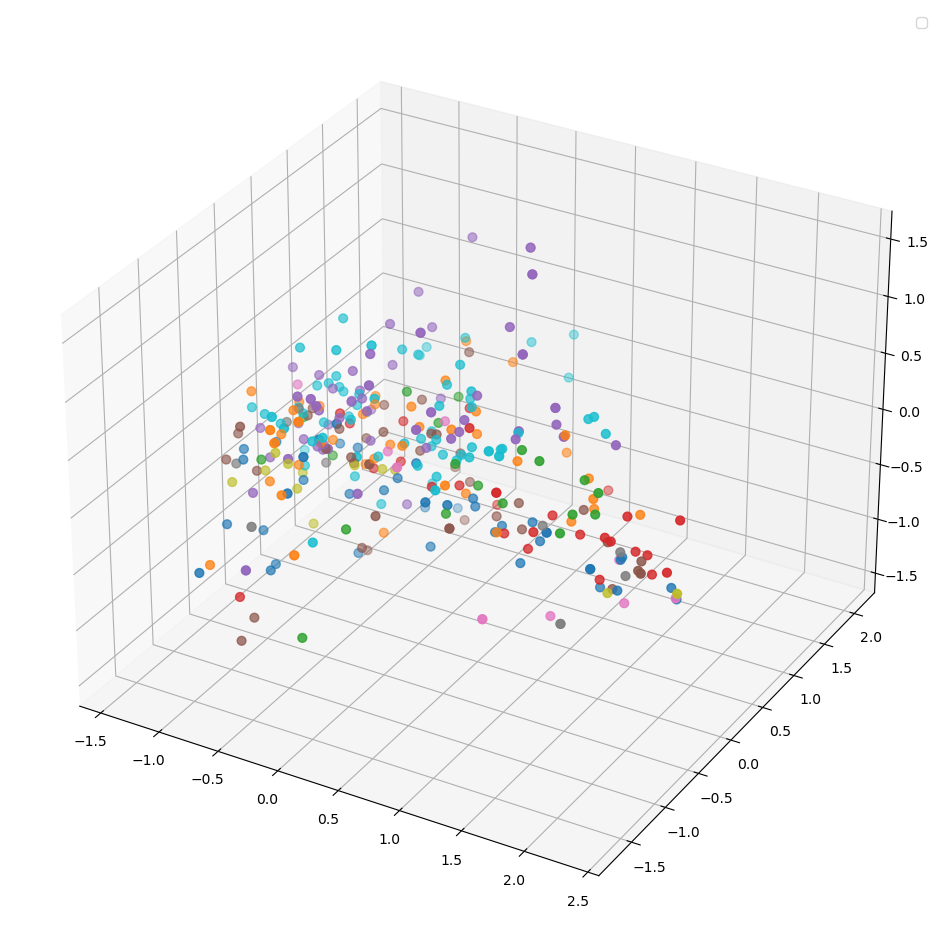

In [254]:
pca = PCA(n_components=3)
res = pca.fit_transform(stock2vec)
fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.scatter3D(res[:, 0], res[:, 1], res[:, 2], c=visDF.col, s=40)
ax.legend()

## Rolling our own Word2Vec

We will take the Wikipedia corpus, which needs some down breaking.
A document in wiki contains a bunch of sections, which can be parsed into sentences. They then still need to be word-tokenized.
https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

This takes some time. You might want to limit this to a few 100 or 1000 articles to train on. Inspect, how meaningful parallelograms and similarities are with your own model. Word2Vec takes a sentence generator-like object (try to avoid an explicit list, as it gobbles your memory). It is a class that needs to implement the `__iter__` method.

It should yield sentences in the form of a list(!) of words! Like this:
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals']'

The cells below show how the wiki corpus datastructure can be broken down. Explore this and then complete the SentenceGenerator code.


In [410]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize

class SentenceGenerator:
    def __iter__(self):        
        ## breaking down wikipedia articles
        count = 0
        for doc in wiki:
            count += 1
            for section in doc['section_texts']:                
                for sentence in sent_tokenize(section):
                    yield simple_preprocess(sentence)
            if count == 1000: break
                
wiki = api.load('wiki-english-20171001')                
sentences = SentenceGenerator()

myW2V = Word2Vec(sentences=sentences, vector_size=200, min_count=10)

Once the training succeeded, your result object has a wv
Excercise: find out, how you can play with the vector size, so to set it to e.g. 200. What is the default? Also, find out, whether Word2Vec has a way to train models for ridiculous words that occur only once or extremely rarely, like 'jajajajajajajajajajajajajajajajajajajajajajajajajajajajajajaja'<font size="15">🧐</font>

In [412]:
len(myW2V.wv.index_to_key)

19776

In [414]:
myW2V.wv.most_similar('the')

[('entire', 0.42735743522644043), ('full', 0.4265236258506775), ('third', 0.4054695963859558), ('section', 0.4053959548473358), ('line', 0.4051755666732788), ('rise', 0.4000672399997711), ('akkad', 0.3992515206336975), ('second', 0.39760586619377136), ('succession', 0.39302319288253784), ('map', 0.39121896028518677)]

In [210]:
myW2V.wv.similarity('new', 'york')

0.35123312

In [186]:
## here is an alternative corpus to learn from
from gensim.test.utils import datapath
from gensim import utils

corpus_path = datapath('lee_background.cor')
for line in open(corpus_path):
    print(line)
    print(simple_preprocess(line))
    break

Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year's Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are available at this

In [89]:
for doc in wiki:
    break
doc.keys()

dict_keys(['section_texts', 'section_titles', 'title'])

In [96]:
## a section can be sentence tokenized like so:
sent_tokenize(doc['section_texts'][0])

["\n\n\n\n\n'''Anarchism''' is a political philosophy that advocates self-governed societies based on voluntary institutions.",
 'These are often described as stateless societies, although several authors have defined them more specifically as institutions based on non-hierarchical free associations.',
 'Anarchism holds the state to be undesirable, unnecessary and harmful.',
 'While anti-statism is central, anarchism specifically entails opposing authority or hierarchical organisation in the conduct of all human relations, including—but not limited to—the state system.',
 'Anarchism is usually considered a far-left ideology and much of anarchist economics and anarchist legal philosophy reflects anti-authoritarian interpretations of communism, collectivism, syndicalism, mutualism or participatory economics.',
 'Anarchism does not offer a fixed body of doctrine from a single particular world view, instead fluxing and flowing as a philosophy.',
 'Many types and traditions of anarchism exi

In [85]:
## text8 is a bit smaller. Note this doesn't have the sentences any more
text8 = api.load("text8")

[==================================================] 100.0% 31.6/31.6MB downloaded


In [178]:
%pprint
for doc in text8:
    break
doc

Pretty printing has been turned OFF


['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing', 'interpretations', 'of', 'what', 'this', 'means', 'anarchism', 'also', 'refers', 'to', 'related', 'so